## Solving MNIST Dataset

In this notebook we are going to utilize GPU for solving the MNIST Dataset which is available as one of the Torchvision datasets.

Lets start by importing the necessary packages.

In [1]:
##importing the packages

import torch
import torchvision
from torchvision.transforms import transforms

from torchvision.datasets import MNIST

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt

Lets import the dataset and since the dataset consist of images we are going to transform them into flattened tensors.

In [2]:
mnist_data = MNIST(root = '/data' , 
                   train = True,
                   transform = transforms.ToTensor(),
                   download = True)

And done!

Now lets check what inside it, by picking one of the element.

In [3]:
img , label = mnist_data[0]

print(img.shape)
print(label)

torch.Size([1, 28, 28])
5


Yep! As expected! The famous MNIST Dataset is loaded.

Lets check the number of images it contains.

In [4]:
len(mnist_data)

60000

Lets visualize one of the randomly picked sample.

Label is :  3


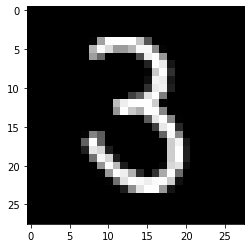

In [5]:
np.random.seed(33)
idx = int(np.random.choice(len(mnist_data) , 1))  ##picks one random number from 60,000

img , label = mnist_data[idx]

## Visualization ##
## Matplotlib expects the datachannel in the last axis and not in the first one ##
img = img.reshape(img.shape[1] , img.shape[2]) ##reshaping the image into 28 * 28

plt.imshow(img , cmap = 'gray')
print('Label is : ' , label)

Okay, cool as a whistle!

Now what?

Well I love fixing our model, then moving ahead. So in this notebook we are going to implement a 2 layered model with the first hidden layer getting an activation function to impose non-linearity!

Now why do we need non-linearity? Well if we simply put linear models, the entire model would make similar thiongs as that of a Linear Regression. Now, think about it, does the pixels of an image have linear relationship with the output target? No, right? Thats why we integrate non-linearity.

So, lets set our model and we will make it a bit generic.

In [6]:
class mnist_model(nn.Module):
    def __init__(self , input_size , hidden_size , output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size , hidden_size)
        self.linear2 = nn.Linear(hidden_size , output_size)
        
    def forward(self , xb):
        xb = xb.reshape(xb.size(0) , -1)
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        return out
    
model = mnist_model(784 , 32 , 10)  ##setting an instance of the model

Now we set up our loss function and optimizer.

In [7]:
## Loss Function ##
loss_function = F.cross_entropy

## Optimizer ##
optimizer = torch.optim.Adam(model.parameters() , lr = 1e-1)

Done! Now lets split up our data by shuffling.

In [8]:
def split_index(dataset_size , split_percent):
    split_size = int(dataset_size * split_percent)
    random_idx = np.random.permutation(dataset_size)
    
    return random_idx[:split_size] , random_idx[split_size:]

Thats all set up.

We should store the indexes now.

In [9]:
val_idx , train_idx = split_index(len(mnist_data) , 0.10)  

print('Validation set length :' , len(val_idx))
print('Train set length :' , len(train_idx))

Validation set length : 6000
Train set length : 54000


And its all set!

Now the main purpoe of this notebook is to utilize the Cuda implementation which is not automatic in Pytorch, and have to be explicitly defined for implementation. So, lets define a model which would check for cuda availability and set the torch device as cuda.

In [10]:
def gpu_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    
    else:
        return torch.device('cpu')

Lets check our device then!

In [11]:
device = gpu_device()
device

device(type='cuda')

Yes! Our cuda is showing. Now for implementation we need to transfer data to cuda explicitly, so lets define a function like that.

In [12]:
def move_to_device(data , device):
    if isinstance(data , (list , tuple)):
        return [move_to_device(x , device) for x in data]
    return data.to(device , non_blocking = True)

Done! 
Now lets set up our datalaoder and also implement our gpu integration

In [13]:
train_sampler = SubsetRandomSampler(train_idx)
train_dl = DataLoader(mnist_data , batch_size = 512, sampler = train_sampler)

val_sampler = SubsetRandomSampler(val_idx)
val_dl = DataLoader(mnist_data , batch_size = 512, sampler = val_sampler)

And we have set our datalaoders.
Now lets implement a class which would put them into gpu whenever iteratively called.

In [14]:
class gpu_dataloader():
    def __init__(self, dl , device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for batches in self.dl:
            yield move_to_device(batches , self.device)
    
    def __len__(self):
        return len(self.dl)

Lets transform the basic dataloaders in gpu dataloaders.

In [15]:
train_dataloader = gpu_dataloader(train_dl , device)
val_dataloader = gpu_dataloader(val_dl , device)

And done!

Now all we need is a metric function!

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Done!

Now lets build our training part and validation part of the codes in two functions.

In [17]:
def fit(model , train_dl , val_dl , loss_func , optim , num_epochs):
    
    acc = []
    losses = []
    for epochs in range(num_epochs):
        
        for xb , yb in train_dl:
            ## making prediction
            pred = model(xb)
            
            ## calculating loss function
            loss = loss_func(pred , yb)
    
            ##calculating gradients
            loss.backward()
    
            ##one step of optimization
            optim.step()
    
            ##reset the gradient
            optim.zero_grad()
            
        for val_x , val_y in val_dl:
            
            with torch.no_grad():
                
                ##calculating the prediction
                
                val_pred = model(val_x)
                
                val_loss = loss_func(val_pred , val_y)
                
                ##storing the validation loss
                losses.append(val_loss)
                
                ##getting accuracy
                res = accuracy(F.softmax(val_pred , dim = 1) , val_y)
                
                ##storing the accuracy
                acc.append(res)
                
        print('Epochs [ {} / {}] :- Loss : {:.4f} , Accuracy : {:.4f}'.format(epochs + 1 , num_epochs , val_loss , res))
        
    return acc , losses

We are going to train our model, but before that we must move our model to cuda.

In [18]:
model = move_to_device(model , device)

In [19]:
next(model.parameters()).is_cuda  ##checking if the model is in cuda

True

Lets train!

In [20]:
history = fit(model , train_dataloader , val_dataloader , loss_function , optimizer , 20)

Epochs [ 1 / 20] :- Loss : 0.4579 , Accuracy : 0.8641
Epochs [ 2 / 20] :- Loss : 0.3700 , Accuracy : 0.9185
Epochs [ 3 / 20] :- Loss : 0.3039 , Accuracy : 0.9239
Epochs [ 4 / 20] :- Loss : 0.3642 , Accuracy : 0.8859
Epochs [ 5 / 20] :- Loss : 0.2850 , Accuracy : 0.9185
Epochs [ 6 / 20] :- Loss : 0.3545 , Accuracy : 0.8967
Epochs [ 7 / 20] :- Loss : 0.3171 , Accuracy : 0.9266
Epochs [ 8 / 20] :- Loss : 0.3041 , Accuracy : 0.9239
Epochs [ 9 / 20] :- Loss : 0.4211 , Accuracy : 0.9130
Epochs [ 10 / 20] :- Loss : 0.2550 , Accuracy : 0.9375
Epochs [ 11 / 20] :- Loss : 0.3694 , Accuracy : 0.9212
Epochs [ 12 / 20] :- Loss : 0.4135 , Accuracy : 0.9103
Epochs [ 13 / 20] :- Loss : 0.4077 , Accuracy : 0.9076
Epochs [ 14 / 20] :- Loss : 0.2950 , Accuracy : 0.9402
Epochs [ 15 / 20] :- Loss : 0.3605 , Accuracy : 0.9293
Epochs [ 16 / 20] :- Loss : 0.2665 , Accuracy : 0.9185
Epochs [ 17 / 20] :- Loss : 0.4005 , Accuracy : 0.9185
Epochs [ 18 / 20] :- Loss : 0.4177 , Accuracy : 0.8940
Epochs [ 19 / 20] :

And done!